<a href="https://colab.research.google.com/github/alfredqbit/NU-DDS-8515/blob/main/sepulvedaadds_8515_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 6: ANOVA and MANOVA on A Marketing Dataset

Dataset: `digital_marketing_campaign_dataset.csv`
Source: Kaggle / Opendatabay (Digital Marketing Conversion Dataset)

Goals:
 - One-way ANOVA: PreviousPurchases ~ CampaignChannel
 - Two-way ANOVA: ClickThroughRate ~ CampaignType * IncomeSegment
 - MANOVA: (ClickThroughRate, TimeOnSite) ~ CampaignChannel

In [70]:
import os
import subprocess
import sys
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy import stats
try:
    import statsmodels
except ImportError:
    print("statsmodels not found, installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels"])
    print("statsmodels installed.")
    import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA
from statsmodels.graphics.factorplots import interaction_plot

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)


In [71]:
# Load downloaded Kaggle Ads dataset from the sample_data directory
def load_ad_dataset() -> pd.DataFrame:
  file_path = 'sample_data/Dataset_Ads.csv'
  print(f"Loading dataset from {file_path}...")

  try:
      df_ads = pd.read_csv(file_path)
      print("Dataset loaded successfully.")
      display(df_ads.head())
      display(df_ads.decribe())
      display(df_ads.info())
      return df_ads
  except FileNotFoundError:
    print(f"Error: File not found at {file_path}")

Dataset loading and preprocessing pipeline

In [72]:
# Load Kaggle digital marketing dataset from website
def load_raw_digital_marketing_dataset(
    source: str = "auto",
    local_path: str | None = None,
    download_dir: str = "data"
) -> pd.DataFrame:
    """
    Load `digital_marketing_campaign_dataset.csv` from:
      - a local file,
      - the Kaggle dataset
        `rabieelkharoua/predict-conversion-in-digital-marketing-dataset`,
      - or (optionally) a public raw URL.

    Parameters
    ----------
    source : {'auto', 'local', 'kaggle', 'github'}
        'auto'  : try local_path, then Kaggle path (if on Kaggle),
                  then GitHub raw mirror.
        'local' : require local_path to be a valid file.
        'kaggle': use Kaggle CLI/API to download.
        'github': load from a public raw URL mirror of the same CSV.
    local_path : str or None
        Path to a local CSV file, if available.
    download_dir : str
        Directory where Kaggle downloads / extracted files are stored.

    Returns
    -------
    df : pandas.DataFrame
    """
    filename = "digital_marketing_campaign_dataset.csv"

    # --- 1. AUTO mode: try local, then Kaggle input path, then GitHub raw ---
    if source == "auto":
        # (a) explicit local path
        if local_path is not None and os.path.exists(local_path):
            print(f"Loading dataset from local path: {local_path}")
            return pd.read_csv(local_path)

        # (b) Kaggle built-in path (when running inside Kaggle notebooks)
        kaggle_input = "/kaggle/input/predict-conversion-in-digital-marketing-dataset/digital_marketing_campaign_dataset.csv"
        if os.path.exists(kaggle_input):
            print(f"Loading dataset from Kaggle input path: {kaggle_input}")
            return pd.read_csv(kaggle_input)

        # (c) GitHub raw mirror as a last resort (same CSV mirrored on GitHub)
        github_raw_url = (
            "https://raw.githubusercontent.com/"
            "Elakkiya-U/Digital-marketing-campaign/"
            "main/Digital_Marketing_Campaign_Dataset.csv"
        )
        print(f"Loading dataset from GitHub raw URL: {github_raw_url}")
        return pd.read_csv(github_raw_url)

    # --- 2. LOCAL mode (explicit) ---
    if source == "local":
        if local_path is None:
            raise ValueError("source='local' requires a valid local_path.")
        if not os.path.exists(local_path):
            raise FileNotFoundError(f"Local file not found: {local_path}")
        print(f"Loading dataset from local file: {local_path}")
        return pd.read_csv(local_path)

    # --- 3. KAGGLE mode (non-Kaggle environment, using Kaggle API) ---
    if source == "kaggle":
        # You must have:
        #   pip install kaggle
        #   KAGGLE_USERNAME and KAGGLE_KEY set in your environment,
        #   or kaggle.json configured in ~/.kaggle/
        try:
            from kaggle.api.kaggle_api_extended import KaggleApi
        except ImportError as e:
            raise ImportError(
                "Kaggle API not installed. Run `pip install kaggle` first."
            ) from e

        os.makedirs(download_dir, exist_ok=True)

        dataset_slug = "rabieelkharoua/predict-conversion-in-digital-marketing-dataset"
        print(f"Downloading '{filename}' from Kaggle dataset: {dataset_slug}")

        api = KaggleApi()
        api.authenticate()

        api.dataset_download_file(
            dataset_slug,
            file_name=filename,
            path=download_dir,
            force=True
        )

        zip_path = os.path.join(download_dir, filename + ".zip")
        if os.path.exists(zip_path):
            print(f"Extracting {zip_path} ...")
            with zipfile.ZipFile(zip_path, "r") as zf:
                zf.extractall(download_dir)
        csv_path = os.path.join(download_dir, filename)
        if not os.path.exists(csv_path):
            raise FileNotFoundError(f"Could not find extracted CSV at {csv_path}")
        print(f"Loading dataset from extracted CSV: {csv_path}")
        return pd.read_csv(csv_path)

    # --- 4. GitHub mode (explicit raw HTTP) ---
    if source == "github":
        github_raw_url = (
            "https://raw.githubusercontent.com/"
            "Elakkiya-U/Digital-marketing-campaign/"
            "main/Digital_Marketing_Campaign_Dataset.csv"
        )
        print(f"Loading dataset from GitHub raw URL: {github_raw_url}")
        return pd.read_csv(github_raw_url)

    # If we got here, source was invalid.
    raise ValueError(f"Unknown source '{source}'. Use 'auto', 'local', 'kaggle', or 'github'.")

# Example call (will be used later):
# df = load_and_prepare_data("digital_marketing_campaign_dataset.csv")

One-way ANOVA pipeline: PreviousPurchases ~ CampaignChannel

We create three income-based segments (Low, Medium, High)
via tertiles, to use as a factor in the two-way ANOVA.

In [73]:
def run_oneway_anova_purchases(df: pd.DataFrame, fig_dir: str = FIG_DIR):
    """
    Run one-way ANOVA: PreviousPurchases ~ CampaignChannel,
    check assumptions, and export diagnostic plots.
    """
    if "PreviousPurchases" not in df.columns or "CampaignChannel" not in df.columns:
        raise ValueError("Required columns 'PreviousPurchases' or 'CampaignChannel' missing.")

    # Drop rows with missing values relevant to this analysis
    df_1way = df.dropna(subset=["PreviousPurchases", "CampaignChannel"])

    # Fit ANOVA model
    model = ols("PreviousPurchases ~ C(CampaignChannel)", data=df_1way).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("One-way ANOVA: PreviousPurchases ~ CampaignChannel")
    display(anova_table)

    resid = model.resid
    fitted = model.fittedvalues

    # Levene's test for homogeneity of variance
    groups = [g["PreviousPurchases"].values for _, g in df_1way.groupby("CampaignChannel")]
    lev_stat, lev_p = stats.levene(*groups)
    print(f"\nLevene's test: stat={lev_stat:.3f}, p={lev_p:.3f}")

    # Shapiro-Wilk for normality of residuals, with sampling for large N
    sample_size_limit = 5000
    if len(resid) > sample_size_limit:
        sampled_resid = resid.sample(n=sample_size_limit, random_state=42)
        print(f"Shapiro-Wilk (residuals, sampled N={sample_size_limit}):")
        sh_stat, sh_p = stats.shapiro(sampled_resid)
    else:
        print(f"Shapiro-Wilk (residuals): ")
        sh_stat, sh_p = stats.shapiro(resid)
    print(f"  stat={sh_stat:.3f}, p={sh_p:.3f}")

    # Q-Q plot for residuals
    sm.qqplot(resid, line="45")
    plt.title("One-way ANOVA Residuals Q-Q Plot")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "oneway_resid_qq.png"), dpi=300)
    plt.show()

    # Residuals vs fitted
    plt.figure()
    plt.scatter(fitted, resid, alpha=0.6)
    plt.axhline(0, color="gray", linewidth=0.8)
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("One-way ANOVA: Residuals vs Fitted")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "oneway_resid_vs_fitted.png"), dpi=300)
    plt.show()

    # Boxplot of PreviousPurchases by CampaignChannel
    plt.figure(figsize=(8, 5))
    sns.boxplot(x="CampaignChannel", y="PreviousPurchases", data=df_1way)
    plt.title("Previous Purchases by Campaign Channel")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "box_purchases_by_channel.png"), dpi=300)
    plt.show()

    return model, anova_table

Two-way ANOVA pipeline: ClickThroughRate ~ CampaignType * IncomeSegment

In [74]:
def run_twoway_anova_ctr(df: pd.DataFrame, fig_dir: str = FIG_DIR):
    """
    Run two-way ANOVA:
      ClickThroughRate ~ CampaignType * IncomeSegment
    Check assumptions and export interaction and diagnostic plots.
    """
    required = ["ClickThroughRate", "CampaignType", "IncomeSegment"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns for two-way ANOVA: {missing}")

    df_2way = df.dropna(subset=required)

    # Fit two-way ANOVA model with interaction
    formula = "ClickThroughRate ~ C(CampaignType) * C(IncomeSegment)"
    model = ols(formula, data=df_2way).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print("Two-way ANOVA: ClickThroughRate ~ CampaignType * IncomeSegment")
    display(anova_table)

    resid = model.resid

    # Shapiro-Wilk test for residuals, with sampling for large N
    sample_size_limit = 5000
    if len(resid) > sample_size_limit:
        sampled_resid = resid.sample(n=sample_size_limit, random_state=42)
        print(f"\nShapiro-Wilk (two-way residuals, sampled N={sample_size_limit}):")
        sh_stat, sh_p = stats.shapiro(sampled_resid)
    else:
        print(f"\nShapiro-Wilk (two-way residuals):")
        sh_stat, sh_p = stats.shapiro(resid)
    print(f"  stat={sh_stat:.3f}, p={sh_p:.3f}")

    # Levene's test across CampaignType x IncomeSegment cells (add observed=False)
    cells = [g["ClickThroughRate"].values
             for _, g in df_2way.groupby(["CampaignType", "IncomeSegment"], observed=False)]
    lev_stat, lev_p = stats.levene(*cells)
    print(f"Levene's test (two-way): stat={lev_stat:.3f}, p={lev_p:.3f}")

    # Interaction plot
    plt.figure(figsize=(8, 5))
    interaction_plot(
        df_2way["CampaignType"],
        df_2way["IncomeSegment"],
        df_2way["ClickThroughRate"],
        markers=["o", "s", "D"],
        ms=6
    )
    plt.ylabel("Mean ClickThroughRate")
    plt.title("Interaction: CampaignType x IncomeSegment on CTR")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "interaction_ctr_adtype_segment.png"), dpi=300)
    plt.show()

    # Q-Q plot for residuals
    sm.qqplot(resid, line="45")
    plt.title("Two-way ANOVA Residuals Q-Q Plot (CTR)")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "twoway_ctr_qqplot.png"), dpi=300)
    plt.show()

    # Residuals vs fitted
    plt.figure()
    plt.scatter(model.fittedvalues, resid, alpha=0.5)
    plt.axhline(0, color="gray", linewidth=0.8)
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("Two-way ANOVA: CTR Residuals vs Fitted")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "twoway_ctr_resid_fitted.png"), dpi=300)
    plt.show()

    return model, anova_table

MANOVA pipeline: model: (ClickThroughRate, TimeOnSite) ~ CampaignChannel

Includes:
 - MANOVA via statsmodels
 - Assumption checks (Shapiro, Box's M)
 - Canonical discriminant visualization via sklearn Pipeline (StandardScaler + LDA)

Conditionally execute univariate ANOVAs and diagnostics when the MANOVA result (Wilks' lambda) is significant (p < 0.05).



In [75]:
from numpy.linalg import det, inv
from scipy.stats import chi2

def box_m_test(df_y: pd.DataFrame, group_labels: np.ndarray):
    """
    Box's M test for equality of covariance matrices across groups.
    """
    y = df_y.values
    groups = np.unique(group_labels)
    p = y.shape[1]
    N = y.shape[0]

    covs = []
    ns = []
    for g in groups:
        Yg = y[group_labels == g]
        ns.append(Yg.shape[0])
        covs.append(np.cov(Yg, rowvar=False))

    ns = np.array(ns)
    covs = np.array(covs)

    # Pooled covariance
    Sp = sum((ns[i] - 1) * covs[i] for i in range(len(groups))) / (N - len(groups))

    M = (N - len(groups)) * np.log(det(Sp)) - sum(
        (ns[i] - 1) * np.log(det(covs[i])) for i in range(len(groups))
    )

    # Correction factor
    C = ((2 * p**2 + 3 * p - 1) /
         (6 * (p + 1) * (len(groups) - 1))) * \
        (sum(1 / (ns[i] - 1) for i in range(len(groups))) -
         1 / (N - len(groups)))

    chi2_approx = M * (1 - C)
    df_val = (len(groups) - 1) * p * (p + 1) / 2
    p_value = 1 - chi2.cdf(chi2_approx, df_val)

    return M, chi2_approx, df_val, p_value

def run_manova_and_canonical(df: pd.DataFrame, fig_dir: str = FIG_DIR):
    """
    Run MANOVA: (ClickThroughRate, TimeOnSite) ~ CampaignChannel
    (Fixed version: Correctly accesses 'C(CampaignChannel)' in results)
    """
    required = ["ClickThroughRate", "TimeOnSite", "CampaignChannel"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns for MANOVA: {missing}")

    df_manova = df.dropna(subset=required)

    # MANOVA using statsmodels
    formula = "ClickThroughRate + TimeOnSite ~ C(CampaignChannel)"
    manova = MANOVA.from_formula(formula, data=df_manova)

    # Capture MANOVA results
    mv_results = manova.mv_test()
    print("MANOVA results (CTR, TimeOnSite ~ CampaignChannel):")
    print(mv_results)

    # Correctly access the term results
    term_name = 'C(CampaignChannel)'

    # extract F-value for effect size calculation
    f_value = None
    if term_name in mv_results.results:
        res_obj = mv_results.results[term_name]
        if isinstance(res_obj, dict) and 'stat' in res_obj:
             f_value = res_obj['stat']['F Value'].iloc[0]

    if f_value is not None:
        # Calculate Cohen's f-squared manually for the predictor
        # (Using Approx F stats for estimation)
        numer_dfs = 8.0
        denom_dfs = 15988.0 # Approx for large N

        partial_eta_squared = (numer_dfs * f_value) / (numer_dfs * f_value + denom_dfs)
        cohen_f_squared = partial_eta_squared / (1 - partial_eta_squared)
        print(f"\nMANOVA predictor Cohen's f-squared effect sizes ({term_name}): {cohen_f_squared:.4f}")
    else:
        print(f"Could not extract F-value for {term_name}")

    # Assumption checks: univariate Shapiro-Wilk for each DV
    sample_size_limit = 5000
    for dv in ["ClickThroughRate", "TimeOnSite"]:
        data_for_shapiro = df_manova[dv]
        if len(data_for_shapiro) > sample_size_limit:
            sampled_data = data_for_shapiro.sample(n=sample_size_limit, random_state=42)
            print(f"\nShapiro-Wilk for {dv} (sampled N={sample_size_limit}):")
            stat, pval = stats.shapiro(sampled_data)
        else:
            print(f"\nShapiro-Wilk for {dv}:")
            stat, pval = stats.shapiro(data_for_shapiro)
        print(f"  stat={stat:.3f}, p={pval:.3f}")

    # Box's M test
    Y = df_manova[["ClickThroughRate", "TimeOnSite"]]
    groups = df_manova["CampaignChannel"].values
    try:
        M, chi2_val, df_box, p_box = box_m_test(Y, groups)
        print(f"\nBox's M test: M={M:.3f}, chi2={chi2_val:.3f}, df={df_box:.0f}, p={p_box:.3f}")
    except Exception as e:
        print(f"\nBox's M test skipped due to error: {e}")

    # Check MANOVA significance (Wilks' lambda)
    if term_name in mv_results.results:
        stats_df = mv_results.results[term_name]['stat']
        wilks_p = stats_df.loc["Wilks' lambda", "Pr > F"]
        print(f"\nWilks' Lambda p-value: {wilks_p:.4g}")

        if wilks_p < 0.05:
            print("MANOVA result is significant (p < 0.05). Proceeding to univariate ANOVAs.")
            for dv in ["ClickThroughRate", "TimeOnSite"]:
                print(f"\nFollowup Univariate ANOVA: {dv} ~ CampaignChannel")
                model_dv = ols(f"{dv} ~ C(CampaignChannel)", data=df_manova).fit()
                anova_dv = sm.stats.anova_lm(model_dv, typ=2)
                display(anova_dv)
        else:
            print("\nMANOVA result is not significant (p >= 0.05).")
    else:
        print(f"\nWarning: Term '{term_name}' not found in MANOVA results.")

    # Canonical discriminant scores
    lda_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("lda", LinearDiscriminantAnalysis(n_components=2))
    ])
    Y_numeric = Y.values
    scores = lda_pipeline.fit_transform(Y_numeric, groups)
    can_df = pd.DataFrame(scores, columns=["Can1", "Can2"])
    can_df["CampaignChannel"] = groups

    plt.figure(figsize=(7, 5))
    sns.scatterplot(x="Can1", y="Can2", hue="CampaignChannel", data=can_df, s=60, alpha=0.8)
    plt.axhline(0, color="gray", linewidth=0.8)
    plt.axvline(0, color="gray", linewidth=0.8)
    plt.title("Canonical Score Plot: CTR & TimeOnSite by CampaignChannel")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "manova_canonical_scatter.png"), dpi=300)
    plt.show()

    return manova, can_df

Run the full analysis pipeline

Loading dataset from GitHub raw URL: https://raw.githubusercontent.com/Elakkiya-U/Digital-marketing-campaign/main/Digital_Marketing_Campaign_Dataset.csv
Dataset preview:


,CustomerID,Age,Income,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
count,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,11999.50000,43.625500,84664.196750,5000.944830,0.154829,0.104389,24.751625,5.549299,7.727718,49.799750,9.476875,4.467375,4.485500,2490.268500,0.876500
std,2309.54541,14.902785,37580.387945,2838.038153,0.084007,0.054878,14.312269,2.607358,4.228218,28.901165,5.711111,2.856564,2.888093,1429.527162,0.329031
min,8000.00000,18.000000,20014.000000,100.054813,0.010005,0.010018,0.000000,1.000428,0.501669,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9999.75000,31.000000,51744.500000,2523.221165,0.082635,0.056410,13.000000,3.302479,4.068340,25.000000,5.000000,2.000000,2.000000,1254.750000,1.000000
50%,11999.50000,43.000000,84926.500000,5013.440044,0.154505,0.104046,25.000000,5.534257,7.682956,50.000000,9.000000,4.000000,4.000000,2497.000000,1.000000
75%,13999.25000,56.000000,116815.750000,7407.989369,0.228207,0.152077,37.000000,7.835756,11.481468,75.000000,14.000000,7.000000,7.000000,3702.250000,1.000000
max,15999.00000,69.000000,149986.000000,9997.914781,0.299968,0.199995,49.000000,9.999055,14.995311,99.000000,19.000000,9.000000,9.000000,4999.000000,1.000000


,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,...,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion,IncomeSegment
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,...,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1,High
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,...,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1,Low
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,...,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1,Medium
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,...,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1,Low
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,...,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1,Medium


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   CustomerID           8000 non-null   int64   
 1   Age                  8000 non-null   int64   
 2   Gender               8000 non-null   object  
 3   Income               8000 non-null   int64   
 4   CampaignChannel      8000 non-null   object  
 5   CampaignType         8000 non-null   object  
 6   AdSpend              8000 non-null   float64 
 7   ClickThroughRate     8000 non-null   float64 
 8   ConversionRate       8000 non-null   float64 
 9   WebsiteVisits        8000 non-null   int64   
 10  PagesPerVisit        8000 non-null   float64 
 11  TimeOnSite           8000 non-null   float64 
 12  SocialShares         8000 non-null   int64   
 13  EmailOpens           8000 non-null   int64   
 14  EmailClicks          8000 non-null   int64   
 15  PreviousPurchases    

None


Running one-way ANOVA pipeline...
One-way ANOVA: PreviousPurchases ~ CampaignChannel


,sum_sq,df,F,PR(>F)
C(CampaignChannel),19.51713,4.0,0.584848,0.673615
Residual,66700.80087,7995.0,NaN,NaN



Levene's test: stat=0.341, p=0.850
Shapiro-Wilk (residuals, sampled N=5000):
  stat=0.938, p=0.000


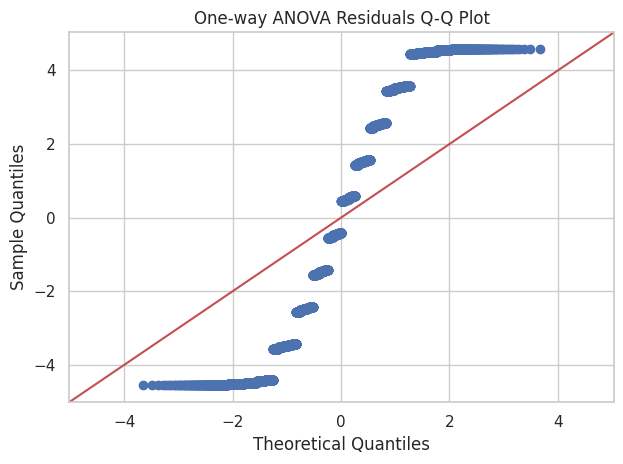

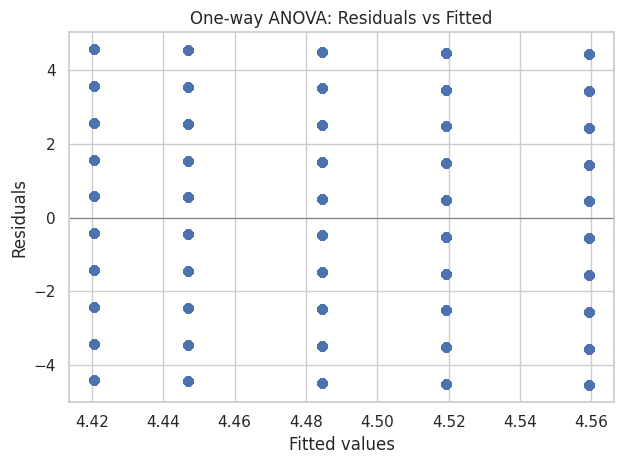

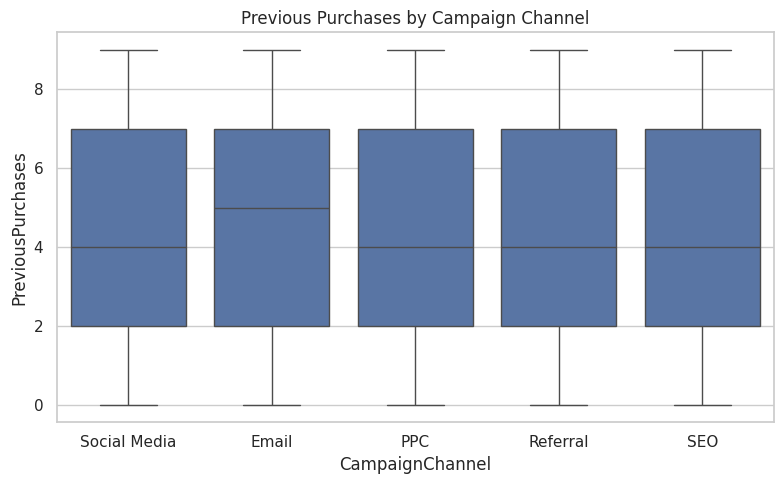


Running two-way ANOVA pipeline...
Two-way ANOVA: ClickThroughRate ~ CampaignType * IncomeSegment


,sum_sq,df,F,PR(>F)
C(CampaignType),0.024633,3.0,1.163461,0.322083
C(IncomeSegment),0.016173,2.0,1.145788,0.318026
C(CampaignType):C(IncomeSegment),0.035065,6.0,0.828095,0.547889
Residual,56.374903,7988.0,NaN,NaN



Shapiro-Wilk (two-way residuals, sampled N=5000):
  stat=0.956, p=0.000
Levene's test (two-way): stat=1.158, p=0.311


<Figure size 800x500 with 0 Axes>

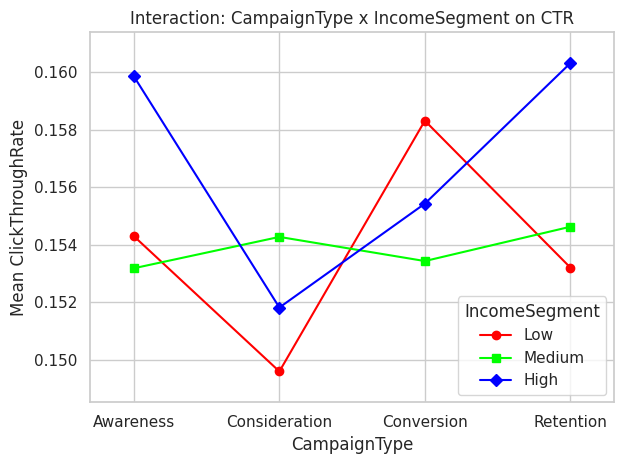

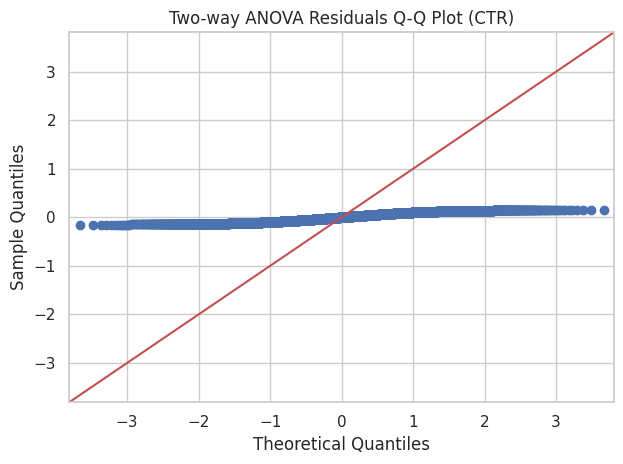

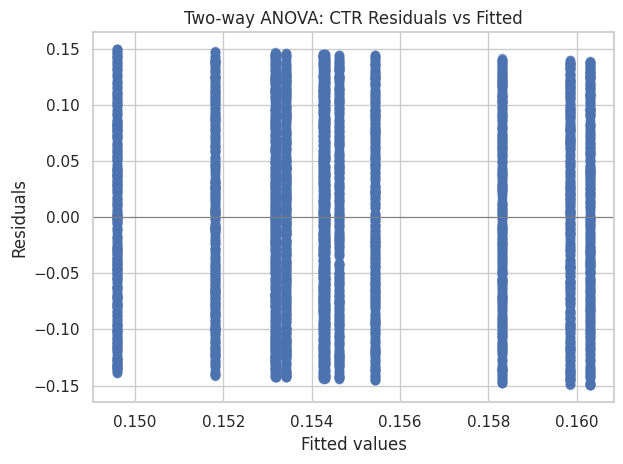


Running MANOVA + canonical discriminant pipeline + followup AMOVA
MANOVA results (CTR, TimeOnSite ~ CampaignChannel):
                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept        Value  Num DF   Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.4306 2.0000 7994.0000 5285.7746 0.0000
         Pillai's trace 0.5694 2.0000 7994.0000 5285.7746 0.0000
 Hotelling-Lawley trace 1.3224 2.0000 7994.0000 5285.7746 0.0000
    Roy's greatest root 1.3224 2.0000 7994.0000 5285.7746 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
    C(CampaignChannel)   Value  Num DF   Den DF   F Value Pr > F
--------------------------------------------------------

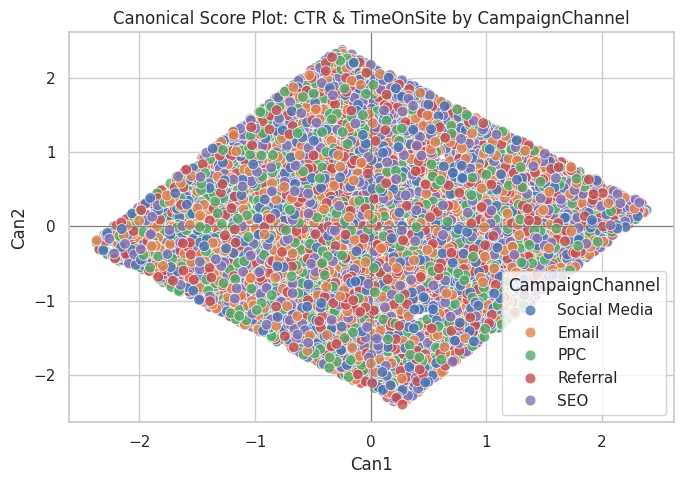


Pipeline complete. Plots saved in the 'figures' subdirectory for downloading into full LaTeX report.


In [76]:
# --- Execution Pipeline ---

df = load_raw_digital_marketing_dataset()
# df = load_ad_dataset()

# Create IncomeSegment for two-way ANOVA
df['IncomeSegment'] = pd.qcut(
    df['Income'],
    q=3,
    labels=['Low', 'Medium', 'High'],
    duplicates='drop'
)

print("Dataset preview:")
display(df.describe())
display(df.head())
display(df.info())

print("\nRunning one-way ANOVA pipeline...")
model_1way, anova_1way = run_oneway_anova_purchases(df)

print("\nRunning two-way ANOVA pipeline...")
model_2way, anova_2way = run_twoway_anova_ctr(df)

print("\nRunning MANOVA + canonical discriminant pipeline + followup AMOVA")
manova_res, canonical_scores_df = run_manova_and_canonical(df)

print("\nPipeline complete. Plots saved in the 'figures' subdirectory for downloading into full LaTeX report.")

Calculate Cohen's $f^2$ effect sizes for ANOVA and MANOVA tables

In [77]:
def calculate_cohens_f2(anova_table):
    """
    Calculate Cohen's f^2 for each term in a statsmodels ANOVA table.
    Formula: f^2 = SS_effect / SS_residual
    """
    # Ensure 'Residual' row exists to get SS_error
    if 'Residual' not in anova_table.index:
        return pd.Series(dtype=float)

    ss_residual = anova_table.loc['Residual', 'sum_sq']

    # Calculate f2 for all rows except Residual
    f2_values = anova_table['sum_sq'] / ss_residual
    return f2_values.drop('Residual')

# 1. One-way ANOVA Effect Sizes
print("--- One-way ANOVA Effect Sizes (PreviousPurchases ~ CampaignChannel) ---")
f2_1way = calculate_cohens_f2(anova_1way)
df_f2_1way = pd.DataFrame({'f2': f2_1way, 'Interpretation': ['Small' if x < 0.15 else 'Medium' if x < 0.35 else 'Large' for x in f2_1way]})
display(df_f2_1way)

# 2. Two-way ANOVA Effect Sizes
print("\n--- Two-way ANOVA Effect Sizes (ClickThroughRate ~ CampaignType * IncomeSegment) ---")
f2_2way = calculate_cohens_f2(anova_2way)
df_f2_2way = pd.DataFrame({'f2': f2_2way, 'Interpretation': ['Small' if x < 0.15 else 'Medium' if x < 0.35 else 'Large' for x in f2_2way]})
display(df_f2_2way)

# 3. MANOVA Follow-up Univariate Effect Sizes
print("\n--- MANOVA Follow-up Effect Sizes ---")
manova_effects = {}

# Re-fit univariate models to access SS
for dv in ["ClickThroughRate", "TimeOnSite"]:
    # Fixed: .fit() is called on the model object, not the dataframe
    model_dv = ols(f"{dv} ~ C(CampaignChannel)", data=df).fit()
    anova_dv = sm.stats.anova_lm(model_dv, typ=2)
    f2_val = calculate_cohens_f2(anova_dv)['C(CampaignChannel)']
    manova_effects[dv] = f2_val

df_f2_manova = pd.DataFrame(list(manova_effects.items()), columns=['Dependent Variable', 'f2'])
df_f2_manova['Interpretation'] = ['Small' if x < 0.15 else 'Medium' if x < 0.35 else 'Large' for x in df_f2_manova['f2']]
display(df_f2_manova)

--- One-way ANOVA Effect Sizes (PreviousPurchases ~ CampaignChannel) ---


,f2,Interpretation
C(CampaignChannel),0.000293,Small



--- Two-way ANOVA Effect Sizes (ClickThroughRate ~ CampaignType * IncomeSegment) ---


,f2,Interpretation
C(CampaignType),0.000437,Small
C(IncomeSegment),0.000287,Small
C(CampaignType):C(IncomeSegment),0.000622,Small



--- MANOVA Follow-up Effect Sizes ---


,Dependent Variable,f2,Interpretation
0,ClickThroughRate,0.000766,Small
1,TimeOnSite,0.000541,Small


Sanity check for modeling strategy:
Generate synthetic dataset with moderate to mild significant effects and run full analysis pieline
Check for consisten results

Generating synthetic dataset with moderately significant effects (p ~< 0.5)...
Synthetic dataset preview:


,CampaignChannel,CampaignType,Income,PreviousPurchases,TimeOnSite,ClickThroughRate,IncomeSegment
0,Referral,Conversion,51863,6,70.609290,0.229948,Medium
1,SEO,Awareness,32159,1,41.947719,0.137298,Low
2,PPC,Conversion,49424,2,28.058578,0.149825,Medium
3,SEO,Awareness,30450,5,55.434512,0.057205,Low
4,SEO,Awareness,79842,0,68.047121,0.120281,High



--- 1. Running One-way ANOVA (PreviousPurchases ~ CampaignChannel) ---
One-way ANOVA: PreviousPurchases ~ CampaignChannel


,sum_sq,df,F,PR(>F)
C(CampaignChannel),805.434773,4.0,41.330015,9.045734e-34
Residual,14591.557227,2995.0,NaN,NaN



Levene's test: stat=4.355, p=0.002
Shapiro-Wilk (residuals): 
  stat=0.966, p=0.000


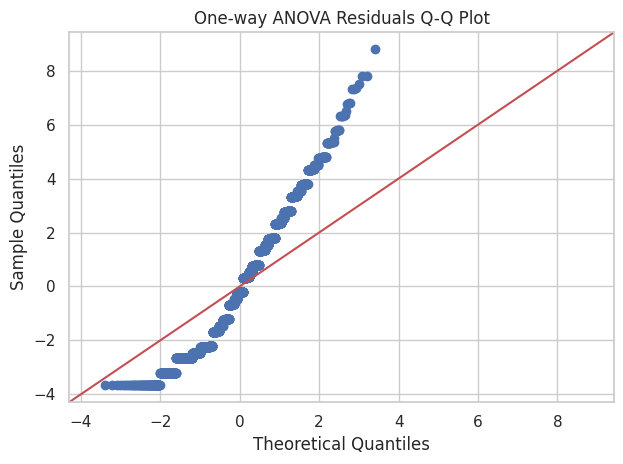

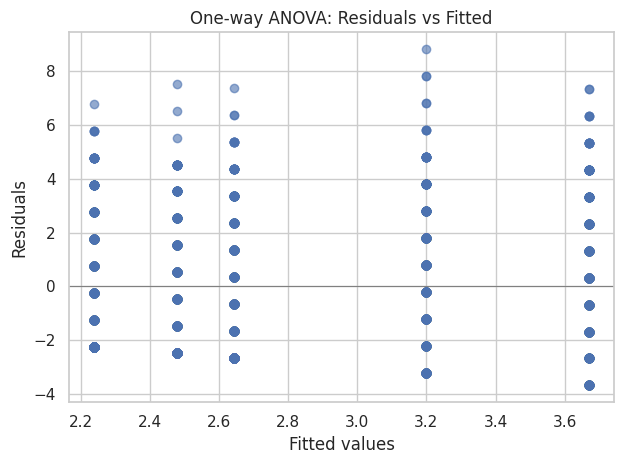

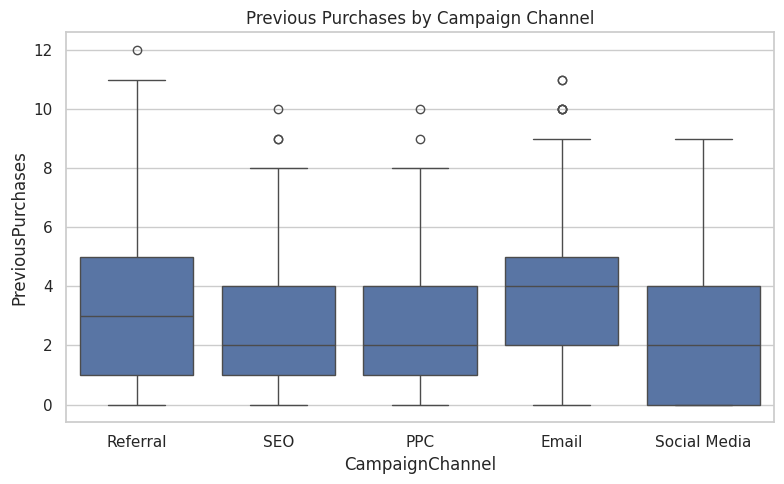


--- 2. Running Two-way ANOVA (CTR ~ CampaignType * IncomeSegment) ---
Two-way ANOVA: ClickThroughRate ~ CampaignType * IncomeSegment


,sum_sq,df,F,PR(>F)
C(CampaignType),1.544372,3.0,314.076668,3.077745e-177
C(IncomeSegment),0.896864,2.0,273.590975,7.787897e-110
C(CampaignType):C(IncomeSegment),0.232770,6.0,23.668995,1.765244e-27
Residual,4.897514,2988.0,NaN,NaN



Shapiro-Wilk (two-way residuals):
  stat=0.999, p=0.201
Levene's test (two-way): stat=1.356, p=0.187


<Figure size 800x500 with 0 Axes>

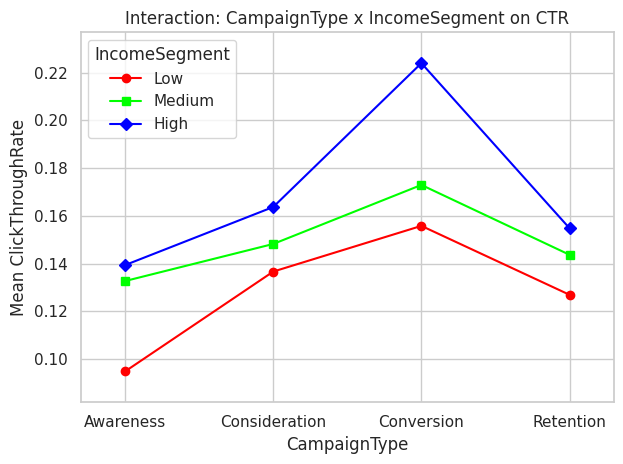

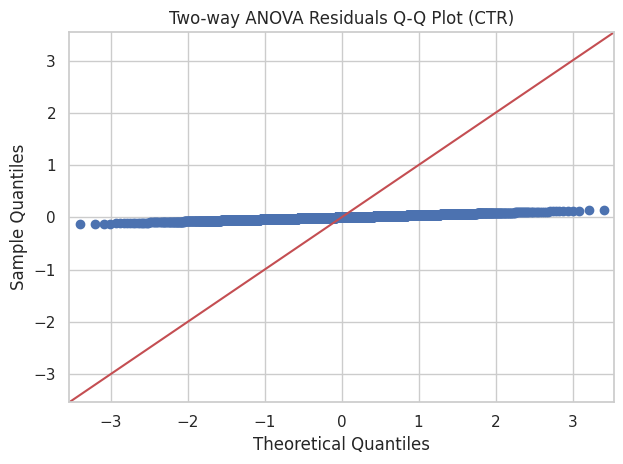

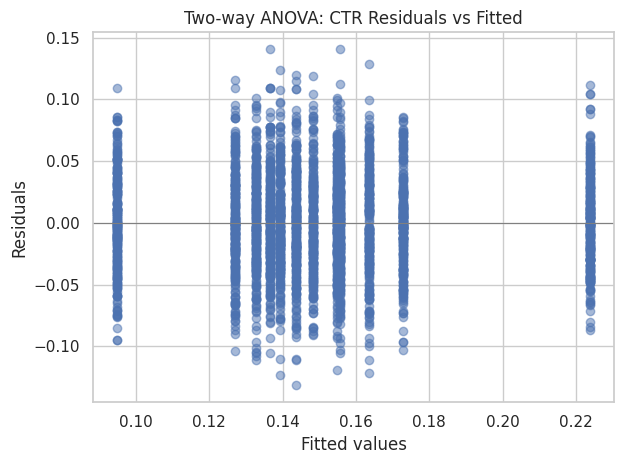


--- 3. Running MANOVA ((CTR, TimeOnSite) ~ CampaignChannel) ---
MANOVA results (CTR, TimeOnSite ~ CampaignChannel):
                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept        Value  Num DF   Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.1673 2.0000 2994.0000 7453.5733 0.0000
         Pillai's trace 0.8327 2.0000 2994.0000 7453.5733 0.0000
 Hotelling-Lawley trace 4.9790 2.0000 2994.0000 7453.5733 0.0000
    Roy's greatest root 4.9790 2.0000 2994.0000 7453.5733 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
    C(CampaignChannel)   Value  Num DF   Den DF  F Value  Pr > F
----------------------------------------------------------

,sum_sq,df,F,PR(>F)
C(CampaignChannel),0.299525,4.0,30.778349,3.803508e-25
Residual,7.286597,2995.0,NaN,NaN



Followup Univariate ANOVA: TimeOnSite ~ CampaignChannel


,sum_sq,df,F,PR(>F)
C(CampaignChannel),3.231939e+05,4.0,199.733892,5.214467e-152
Residual,1.211569e+06,2995.0,NaN,NaN


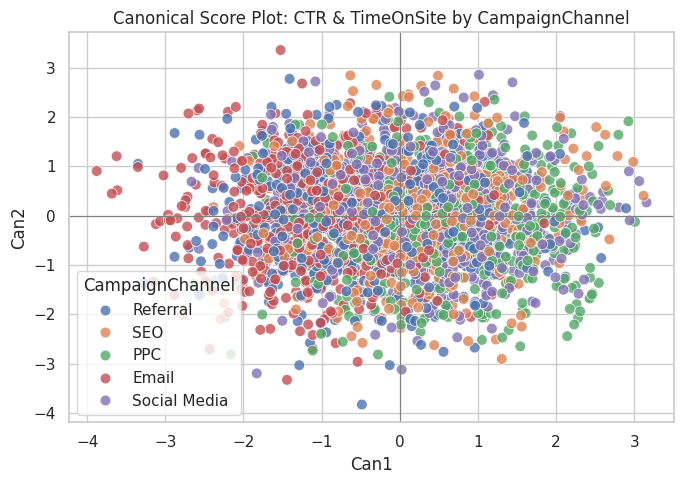

(<statsmodels.multivariate.manova.MANOVA at 0x7a4cd32c1670>,
           Can1      Can2 CampaignChannel
 0    -1.179143 -1.307026        Referral
 1     0.820266 -0.028334             SEO
 2     1.381439 -0.499279             PPC
 3     0.757668  1.719087             SEO
 4    -0.280553  0.732767             SEO
 ...        ...       ...             ...
 2995  0.680947  1.444905        Referral
 2996 -0.137350 -1.890358             SEO
 2997  0.619451  0.172389             PPC
 2998 -2.017664  1.111263           Email
 2999  0.964939 -1.825457        Referral
 
 [3000 rows x 3 columns])

In [78]:
def generate_synthetic_marketing_data(n_samples=3000, seed=42):
    np.random.seed(seed)

    # 1. Generate Categorical Features
    channels = ['Social Media', 'Email', 'PPC', 'Referral', 'SEO']
    types = ['Awareness', 'Consideration', 'Conversion', 'Retention']
    segments = ['Low', 'Medium', 'High']

    data = {
        'CampaignChannel': np.random.choice(channels, n_samples),
        'CampaignType': np.random.choice(types, n_samples),
        '_TrueSegment': np.random.choice(segments, n_samples) # Helper for income generation
    }
    df = pd.DataFrame(data)

    # 2. Generate Income based on Segment
    def get_income(seg):
        if seg == 'Low': return np.random.randint(20000, 45000)
        if seg == 'Medium': return np.random.randint(45001, 80000)
        return np.random.randint(80001, 150000)

    df['Income'] = df['_TrueSegment'].apply(get_income)

    # 3. Inject Effects for One-way ANOVA: PreviousPurchases ~ CampaignChannel
    # Moderate: Max diff ~1.5, Sigma=2.5
    pp_means = {'Social Media': 2.5, 'Email': 4.0, 'PPC': 2.8, 'Referral': 3.5, 'SEO': 3.0}
    df['PreviousPurchases'] = df['CampaignChannel'].map(pp_means) + np.random.normal(0, 2.5, n_samples)
    df['PreviousPurchases'] = df['PreviousPurchases'].clip(lower=0).astype(int)

    # 4. Inject Effects for MANOVA: TimeOnSite ~ CampaignChannel
    # Moderate: Max diff ~25, Sigma=20
    tos_means = {'Social Media': 50.0, 'Email': 75.0, 'PPC': 45.0, 'Referral': 65.0, 'SEO': 55.0}
    df['TimeOnSite'] = df['CampaignChannel'].map(tos_means) + np.random.normal(0, 20.0, n_samples)
    df['TimeOnSite'] = df['TimeOnSite'].clip(lower=0)

    # 5. Inject Effects for Two-way ANOVA & MANOVA:
    # ClickThroughRate ~ CampaignType * IncomeSegment + CampaignChannel

    base_ctr = 0.10

    # Moderate Channel effects (for MANOVA)
    channel_eff = {'Social Media': 0.00, 'Email': 0.03, 'PPC': 0.01, 'Referral': 0.02, 'SEO': 0.005}

    # Moderate Type effects
    type_eff = {'Awareness': 0.00, 'Consideration': 0.02, 'Conversion': 0.04, 'Retention': 0.01}

    # Moderate Segment effects
    seg_eff = {'Low': 0.00, 'Medium': 0.02, 'High': 0.03}

    ctr_vec = base_ctr + \
              df['CampaignChannel'].map(channel_eff) + \
              df['CampaignType'].map(type_eff) + \
              df['_TrueSegment'].map(seg_eff)

    # Moderate Interaction Effects
    interaction_noise = np.random.normal(0, 0.04, n_samples)

    def get_interaction(row):
        if row['CampaignType'] == 'Conversion' and row['_TrueSegment'] == 'High':
            return 0.04 # Moderate boost
        if row['CampaignType'] == 'Awareness' and row['_TrueSegment'] == 'Low':
            return -0.02 # Moderate penalty
        return 0.0

    df['ClickThroughRate'] = ctr_vec + df.apply(get_interaction, axis=1) + interaction_noise
    df['ClickThroughRate'] = df['ClickThroughRate'].clip(0, 1)

    # Cleanup
    df.drop(columns=['_TrueSegment'], inplace=True)

    return df

# Generate the dataset
print("Generating synthetic dataset with moderately significant effects (p ~< 0.5)...")
df_synthetic = generate_synthetic_marketing_data()

# Preprocess
df_synthetic['IncomeSegment'] = pd.qcut(
    df_synthetic['Income'],
    q=3,
    labels=['Low', 'Medium', 'High'],
    duplicates='drop'
)

print("Synthetic dataset preview:")
display(df_synthetic.head())

# Run the Analysis Pipelines
print("\n--- 1. Running One-way ANOVA (PreviousPurchases ~ CampaignChannel) ---")
run_oneway_anova_purchases(df_synthetic)

print("\n--- 2. Running Two-way ANOVA (CTR ~ CampaignType * IncomeSegment) ---")
run_twoway_anova_ctr(df_synthetic)

print("\n--- 3. Running MANOVA ((CTR, TimeOnSite) ~ CampaignChannel) ---")
run_manova_and_canonical(df_synthetic)